In [1]:
import os
import glob

import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from precip_model_functions import *

# Precip data extraction

In [5]:
def concat_pr_trmm(lonlat):
    """returns an array containg the daily precipitation, in mm, in a given box, 
    for all days between 01/1998 and 12/2016 """
    
    allfiles = glob.glob("/global/cfs/projectdirs/m3522/cmip6/obs4mip/NASA-GSFC/TRMM/observations/atmos/pr/3hr/NASA-GSFC/TRMM/*/*")
    allfiles.sort(key = lambda l : l[-28:-16])
    
    allpr=[]
    t=time.time()
    i=0
    for filename in allfiles :
        if "201012311930" in filename:
            continue
        i+=1
        if i%12==0:
            print(i//12)
        pr = xr.open_dataset(filename)
        pr_limited = pr.sel(lon=slice(lonlat[0],lonlat[1]),lat=slice(lonlat[2],lonlat[3])).mean(["lat","lon"]).pr
    
        pr_resampled = pr_limited.resample(time="1D").mean(dim="time")*24*3600
        allpr.append(pr_resampled)
    print(time.time()-t)
    return xr.concat(allpr,"time")
ct = "vietnam"
precip_all = concat_pr_trmm(box[ct]["small"])
precip_all.attrs['units']="mm/day"
precip_all.to_netcdf("/global/cscratch1/sd/qnicolas/data/pr/pr_trmm_%s.nc"%ct)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1
2
3


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


4
5
6
7
8
9
10
11
12
13
14
15
16
23.209509134292603


In [6]:
def concat_pr_era5(lonlat):
    """returns an array containg the daily precipitation, in mm, in a given box, 
    for all days between 01/1979 and 12/2018 """
    
    allfiles = glob.glob("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.generated_tp/*")
    allfiles.sort(key = lambda l : l[-7:-3])
    
    allpr=[]
    t=time.time()
    i=0
    for filename in allfiles :
        i+=1
        print(i)
        pr = xr.open_dataset(filename)
        pr_limited = pr.sel(longitude=slice(lonlat[0],lonlat[1]),latitude=slice(lonlat[3],lonlat[2])).mean(["latitude","longitude"]).tp
    
        pr_resampled = pr_limited.resample(time="1D").sum(dim="time")*1000
        allpr.append(pr_resampled)
    print(time.time()-t)
    return xr.concat(allpr,"time")

precip_all = concat_pr_era5(box[ct]["small"])
precip_all.attrs['units']="mm/day"
precip_all.to_netcdf("/global/cscratch1/sd/qnicolas/data/pr/pr_era5_%s.nc"%ct)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
74.84024453163147


In [15]:
#suffix = "2530N_8090E"
#path_to_precip = "/global/cscratch1/sd/qnicolas/data/pr/pr_"+suffix
#
#months = pd.date_range(start='1/1/1998', end = '12/31/2013', freq='MS')
#monthstr = [str(d)[:4]+str(d)[5:7]+str(d)[8:10] for d in months]
#precip_all = xr.concat([extract(path_to_precip,m)['pr'] for m in monthstr], dim = "time")

ct="vietnam"
#daily_precip_all = xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pr/pr_era5_%s.nc"%ct).tp
#firstyear = 1979
#lastyear = 2018

daily_precip_all = xr.open_dataset("/global/cscratch1/sd/qnicolas/data/pr/pr_trmm_%s.nc"%ct).pr
firstyear = 1998
lastyear = 2013

# r10/r20

In [5]:
r10 = daily_precip_all.where(daily_precip_all>10.,drop=True)
r20 = daily_precip_all.where(daily_precip_all>20.,drop=True)
print("Country : ",ct)
print("nb of days > 10mm : ",len(r10),"  ||  nb of days > 20mm : ",len(r20))
print("r20 breakdown : ")
for s in ['DJF','MAM','JJA','SON']:
    print(s, ' : ', len(r20.sel(time=r20['time.season']==s)))


Country :  nepal
nb of days > 10mm :  1895   ||  nb of days > 20mm :  349
r20 breakdown : 
DJF  :  4
MAM  :  4
JJA  :  305
SON  :  36


# rx1day

In [10]:
season = np.zeros(4)

print("Country : ",ct)
print("rx1 day events : Year / month / precip in mm/day")

for y in range(firstyear,lastyear+1):
    yearly_daily_precip = daily_precip_all.sel(time=daily_precip_all['time.year']==y)
    imax = yearly_daily_precip.argmax('time')
    dmax = yearly_daily_precip[int(imax)]
    date = pd.DatetimeIndex(np.array(dmax.time).reshape(1))[0]
    
    print(date.year,date.month, np.array(dmax).reshape(1)[0])
    season[(date.month%12)//3]+=1
    
print("\nSeason breakdown :")
print("DJF : %i, MAM : %i, JJA : %i, SON : %i"%tuple(season))


Country :  nepal
rx1 day events : Year / month / precip in mm/day
1979 7 30.471119
1980 6 29.37915
1981 6 29.450413
1982 9 24.091383
1983 7 27.32611
1984 7 30.996878
1985 10 33.734043
1986 6 23.660015
1987 8 57.934986
1988 7 47.56333
1989 7 36.01448
1990 8 37.902763
1991 8 30.24603
1992 7 18.70722
1993 8 23.032625
1994 8 24.724483
1995 8 42.24159
1996 7 35.753742
1997 7 44.634468
1998 7 29.63993
1999 7 39.406307
2000 6 28.524845
2001 7 27.826708
2002 7 29.756151
2003 8 40.590157
2004 7 36.08129
2005 7 26.230503
2006 7 26.297085
2007 7 37.371513
2008 6 31.152327
2009 7 37.71986
2010 7 37.67579
2011 6 38.59788
2012 9 29.587706
2013 10 34.669
2014 8 35.720234
2015 7 24.36888
2016 7 27.579603
2017 8 38.572918
2018 7 32.730946

Season breakdown :
DJF : 0, MAM : 0, JJA : 36, SON : 4


# rx5day

In [16]:
season = np.zeros(4)
dates = []

fivedaily_precip_all = daily_precip_all.rolling(time=5, center=True).sum().dropna('time')

print("Country : ",ct)
print("rx5 day events : date / precip in mm/day")

for y in range(firstyear,lastyear+1):
    yearly_fivedaily_precip = fivedaily_precip_all.sel(time=fivedaily_precip_all['time.year']==y)
    imax = yearly_fivedaily_precip.argmax('time')
    dmax = yearly_fivedaily_precip[int(imax)]    
    date = pd.DatetimeIndex(np.array(dmax.time).reshape(1))[0]
    
    print(date.strftime("%Y%m%d"), np.array(dmax).reshape(1)[0])
    season[(date.month%12)//3]+=1
    dates.append(date.strftime("%Y%m%d"))
        
print("\nSeason breakdown :")
print("DJF : %i, MAM : %i, JJA : %i, SON : %i"%tuple(season))
print(dates)

Country :  vietnam
rx5 day events : date / precip in mm/day
19981113 278.5058
19991103 375.6872
20001008 283.2296
20011021 207.33229
20020816 215.99109
20031016 310.52374
20040610 172.40038
20051030 176.83444
20060922 103.46748
20070803 199.2674
20081116 188.99559
20090927 204.33105
20101103 211.12383
20111106 174.76553
20121115 130.27307
20130916 172.81061

Season breakdown :
DJF : 0, MAM : 0, JJA : 3, SON : 13
['19981113', '19991103', '20001008', '20011021', '20020816', '20031016', '20040610', '20051030', '20060922', '20070803', '20081116', '20090927', '20101103', '20111106', '20121115', '20130916']


# 99th percentile

In [17]:
print("Country : ",ct)
print("99th percentile threshold, in mm: ",float(daily_precip_all.quantile(0.99,"time")))

p99 = daily_precip_all.where(daily_precip_all>float(daily_precip_all.quantile(0.99,"time")),drop=True)
print("99th percentile events seasonal breakdown : ")
for s in ['DJF','MAM','JJA','SON']:
    print(s, ' : ', len(p99.sel(time=p99['time.season']==s)))
    
print([pd.DatetimeIndex(np.array(t).reshape(1))[0].strftime("%Y%m%d") for t in p99.time])

Country :  vietnam
99th percentile threshold, in mm:  53.99005050659173
99th percentile events seasonal breakdown : 
DJF  :  5
MAM  :  1
JJA  :  6
SON  :  47
['19981001', '19981002', '19981003', '19981021', '19981112', '19981113', '19981119', '19981125', '19981213', '19991023', '19991024', '19991101', '19991102', '19991103', '19991104', '19991105', '19991210', '19991211', '19991215', '19991216', '20000531', '20000820', '20000821', '20001008', '20001009', '20001116', '20011020', '20011021', '20011111', '20020818', '20021025', '20031015', '20031016', '20031112', '20040612', '20050912', '20051031', '20051101', '20070804', '20071001', '20071002', '20071103', '20071123', '20081117', '20090928', '20090929', '20091016', '20091017', '20091102', '20100823', '20101103', '20101108', '20111106', '20111107', '20121114', '20130917', '20131014', '20131106', '20131115']


## Map of monthly precip 99th percentile

In [2]:
allpr=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc")

In [3]:
#allpr
ninenine = allpr['pr'].quantile(0.99,"time")

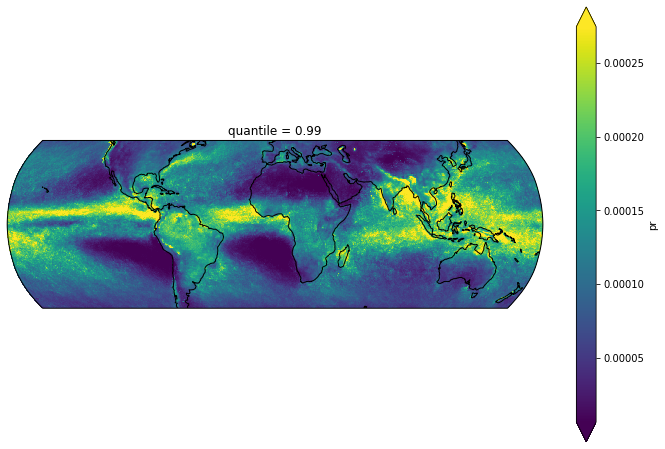

In [4]:

plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
ninenine.plot(ax=ax,transform=ccrs.PlateCarree(),robust=True)

## Rx5 Map from TRMM

In [21]:
pdmonths = [d.strftime("%Y%m") for d in pd.date_range(start = "19980101", end = "20131201", freq='MS')]
rx5s=[]

t = time.time()
for m in pdmonths:
    pr = xr.open_dataset(glob.glob("/global/cfs/projectdirs/m3522/cmip6/obs4mip/NASA-GSFC/TRMM/observations/atmos/pr/3hr/NASA-GSFC/TRMM/*/*%s*.nc"%m)[0])

    pr1D = pr.resample(time='1D').mean().fillna(0)*24*3600
    pr5D_rolling=pr1D.rolling(time=5, center=True).sum()
    rx5 = pr5D_rolling.max("time")
    
    rx5s.append(rx5)
    print(time.time()-t)

rx5a = xr.concat(rx5s,"time")
print(time.time()-t)
rx5 = rx5a.max("time")
print(time.time()-t)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


1.890315055847168


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


3.497018337249756


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


5.42807674407959


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


7.702898740768433


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12.356669902801514


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16.21027946472168
19.674246311187744
23.772517442703247
27.71401858329773
32.26666855812073
37.46951699256897
41.04371213912964


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


44.812522411346436


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


49.70730757713318
55.17981791496277
58.76739025115967


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


62.430322885513306
66.99635434150696
70.84748125076294
74.51011896133423
78.36296105384827
82.85744714736938
86.42957925796509


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


90.24185085296631
94.52746844291687
98.10001969337463
101.95924115180969


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


105.96533346176147
111.39802122116089
115.5642762184143
119.58945751190186
123.82214999198914
127.62796664237976
131.6128339767456


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


136.28753066062927
141.5804271697998
146.55342555046082
150.6145896911621
154.29198837280273
157.64876508712769
161.3303346633911
164.88221669197083
168.56785655021667
172.42676329612732
176.45523262023926
180.24935746192932


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


183.66935348510742
188.17729711532593
192.2027781009674
195.7247350215912
199.62395930290222
203.46429109573364
207.52193760871887
211.18262338638306
216.70923972129822
221.85338640213013
226.14232897758484
230.7779552936554
235.26255249977112
239.5669481754303
243.8384621143341
247.76509404182434
251.99882340431213
256.1661813259125
260.76957869529724
264.72446608543396
269.04769229888916
273.3416006565094
277.00062131881714
281.0413191318512
284.9751343727112
289.06047534942627
293.3035731315613
297.3065438270569
301.1609237194061
305.70345306396484
309.42046070098877
313.26785230636597
318.5496780872345
322.4933371543884
326.27639532089233
330.22210144996643
334.03918862342834
338.167941570282
342.1243815422058
346.30583596229553
350.4170823097229
354.3648273944855
358.15632247924805
361.9059159755707
365.78596782684326
369.96424174308777
373.8095257282257
378.96316957473755


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


382.7667164802551


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


386.7544295787811


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


390.5584235191345


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


394.69613313674927


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


398.5861704349518
402.30633425712585
406.15238761901855
410.22438788414
414.09900307655334
418.6176197528839
422.2033312320709
427.76994585990906
431.4056441783905
435.51960468292236
439.2268023490906
444.71334505081177


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


448.41493678092957
452.15153551101685
455.9953486919403
459.9716565608978
463.7759997844696
468.3001079559326
472.2268052101135
476.1211082935333
480.2365012168884
484.0238890647888
488.1632716655731
492.24733233451843
496.5229799747467
501.20940041542053
505.49195432662964
509.748330116272
513.913745880127
518.0369153022766
521.8442122936249
526.20054936409
530.1274275779724
534.386875629425
538.3863191604614
542.6691200733185
546.5673933029175
550.0524909496307
553.9679510593414
557.6112611293793
561.7811563014984
565.5177135467529
569.3871011734009
573.3233861923218
577.6309239864349
581.4814555644989
585.1993510723114
588.6252167224884
593.4363117218018
597.5351963043213
601.8651192188263
605.9571235179901
610.7364859580994
614.8150112628937
618.5741498470306
622.4428536891937
626.3177056312561
630.288950920105
634.3429217338562
638.2776391506195
642.1283688545227
646.3898804187775
650.8630313873291
655.0468876361847
658.8982548713684
662.723798751831
666.4800417423248
671.01589632

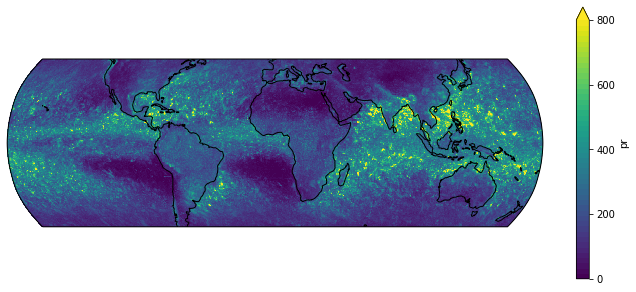

In [25]:
plt.figure(figsize=(12,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()
M=800
rx5.pr.plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0,M), cbar_kwargs={"ticks": np.linspace(0,M,5)})

In [26]:
rx5.to_netcdf("rx5_trmm_1998-2013.nc")

# Nepal - rx5days from GPCP

In [39]:
lonlat = [80, 90, 25, 30]
gpcp = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/obs4mip/observations/NASA-GSFC/Obs-GPCP/GPCP/1DD_v1.3/pr_GPCP-1DD_L3_v1.3_19961001-20161231.nc")
gpcp_spaceaveraged = gpcp.pr.sel(lon=slice(lonlat[0],lonlat[1]),lat=slice(lonlat[2],lonlat[3])).mean(["lat","lon"])
gpcp_spaceaveraged_5d = gpcp_spaceaveraged.rolling(time=5, center=True).sum().dropna('time')*24*3600


0.05305075645446777
0.05907702445983887


In [44]:
season = np.zeros(4)
dates = []

for y in [1997,2014,2015,2016]:
    yearly_gpcp_spaceaveraged_5d = gpcp_spaceaveraged_5d.sel(time=str(y))
    imax = yearly_gpcp_spaceaveraged_5d.argmax('time')
    dmax = yearly_gpcp_spaceaveraged_5d[int(imax)]
    dates.append(dmax)
    
    date = pd.DatetimeIndex(np.array(dmax.time).reshape(1))[0]
    
    print(date, np.array(dmax).reshape(1)[0])
    season[(date.month%12)//3]+=1
        
print(season)

1997-07-10 12:00:00 108.82114
2014-08-13 12:00:00 84.419136
2015-07-14 12:00:00 87.086945
2016-07-20 12:00:00 81.76344
[0. 0. 4. 0.]


In [43]:
gpcp_spaceaveraged_5d

<xarray.DataArray (time: 7393)>
array([58.25841 , 54.19135 , 49.895153, ...,  0.07568 ,  0.07258 ,  0.210816],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1996-10-03T12:00:00 ... 2016-12-29T12:00:00

## Common days between 99th percentile events from trmm and era5

In [3]:
for ct in p99_trmm.keys():
    a = p99_trmm[ct]
    b = p99_era5[ct]
    c = [v for v in a if v in b]
    print(ct)
    print([v for v in a if v in b])
    print(len(c), len (p99_trmm[ct]), len (p99_era5[ct]))
    print("estimated computing time : %i min"%((len (p99_era5[ct])-len(c))*0.75))
    print("")

nepal
['19990710', '20000608', '20020720', '20030708', '20030709', '20030730', '20030818', '20040706', '20040707', '20040708', '20060708', '20070726', '20080614', '20080919', '20090727', '20091006', '20091007', '20100710', '20100718', '20100719', '20110630', '20120705', '20120724', '20120917', '20130617']
25 59 147
estimated computing time : 91 min

pakistan
[]
0 0 0
estimated computing time : 0 min

mexico
[]
0 0 0
estimated computing time : 0 min

chile
[]
0 0 0
estimated computing time : 0 min

Candes
['19980219', '19981222', '19991120', '20040115', '20050116', '20050126', '20051207', '20060111', '20060214', '20070215', '20070216', '20090215', '20110214', '20111122', '20111225', '20130126', '20130203', '20131219']
18 59 147
estimated computing time : 96 min

Sandes
['20000602', '20000603', '20000612', '20000627', '20000909', '20010130', '20010526', '20010527', '20010828', '20020525', '20020824', '20021012', '20030614', '20030619', '20030707', '20040701', '20050528', '20050626', '200